# Data Analytics in Supply Chain


To support the 2020 MSOM Data Driven Research Challenge, JD.com, China’s largest retailer,
offers transaction level data to MSOM members for conducting data-driven research. This article
describes the transactional data associated with over 2.5 million customers (anonymized) and
31,868 SKUs over the month of March in 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from IPython.display import display, HTML, Image, Latex
import time
import random
import math
from pylab import rcParams

import sklearn
import sklearn.linear_model
import statsmodels.api as sm


from tqdm import tqdm_notebook, tqdm

from calendar import Calendar
import datetime

%matplotlib inline
#%qtconsole

# Load Data

In [2]:
orders = pd.read_csv('../Data/JD_order_data.csv')
single_orders = pd.read_csv('../Data/JD_single_orders.csv').drop(columns='Unnamed: 0',axis=1)

# Data Prep

## Order Quantity spread

Some orders have a quantity that is larger than 1. I want use the `value_counts()` function to easily count how many orders have been per hour and the `value_counts()` function will only count every row once. So I made a new data frame `single_orders` that has as many rows as number of SKUs were ordered, that is it converted any row with quantity 2 for example into two separate rows with identical features. 

In [3]:
series = orders.quantity.value_counts().sort_index()

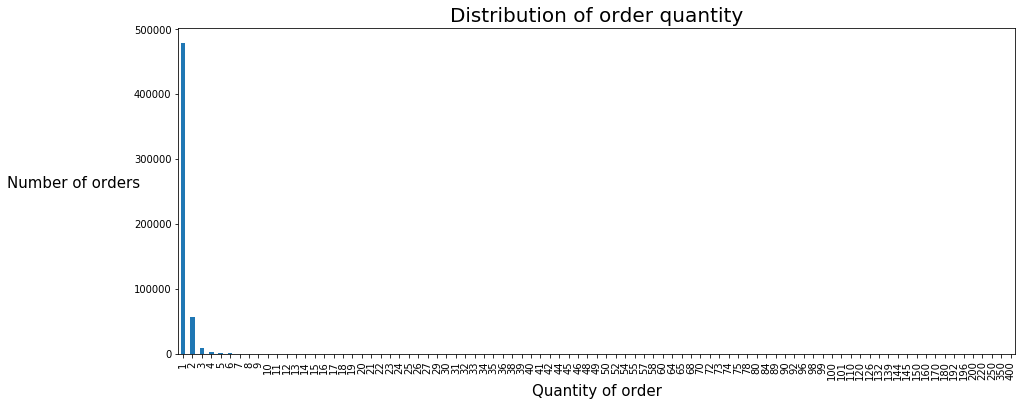

In [4]:
series.plot.bar(x = series.values, y = series.index, figsize = (15, 6));

plt.title('Distribution of order quantity', fontsize = 20)
plt.ylabel('Number of orders', fontsize = 15, rotation=0, labelpad=60)
plt.xlabel('Quantity of order', fontsize = 15);

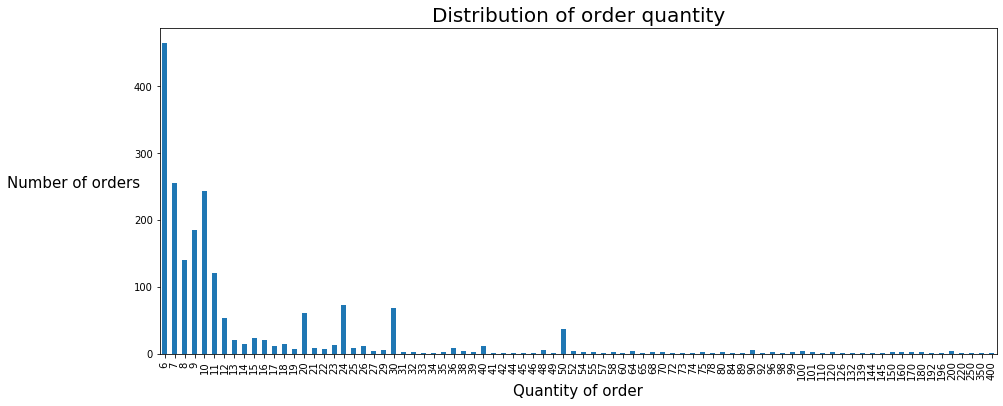

In [5]:
series[5:].plot.bar(x = series[5:].values, y = series[5:].index, figsize = (15, 6));

plt.title('Distribution of order quantity', fontsize = 20)
plt.ylabel('Number of orders', fontsize = 15, rotation=0, labelpad=60)
plt.xlabel('Quantity of order', fontsize = 15);

In [6]:
orders["quantity"].describe()

count    549989.000000
mean          1.216670
std           1.844589
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         400.000000
Name: quantity, dtype: float64

## `single_orders`

In [7]:
# multiple_orders = orders[orders.quantity > 1].reset_index(drop = True)
# single_orders = orders[orders.quantity == 1]

# rows = []
# for i in tqdm_notebook(multiple_orders.index):
#     rows.extend([multiple_orders.loc[i,]]*multiple_orders.loc[i,'quantity'])

# multiple_orders = pd.concat(rows, axis=1).T
# multiple_orders['quantity'] = 1
# single_orders = pd.concat([single_orders, multiple_orders], axis = 0).reset_index(drop=True)

# rows destroys the notebooks memory and performance, so deleting it
# del rows, multiple_orders

# Total number of orders

In [8]:
# prepping data for plotting

sku_orders_date = single_orders[["sku_ID", "order_date"]].copy()

# change the string values to datetime and set it as the index
sku_orders_date['order_date'] = pd.to_datetime(sku_orders_date['order_date'])
sku_orders_date.set_index('order_date', inplace=True);

sku_orders_time = single_orders[["sku_ID", "order_time"]].copy()

# change the string values to datetime and set it as the index
sku_orders_time['order_time'] = pd.to_datetime(sku_orders_time['order_time'])
sku_orders_time.set_index('order_time', inplace=True)

In [9]:
days = Calendar()
days_march = [m for m in days.itermonthdates(2018, 3) if m.month == 3]
days_hours_march = [datetime.datetime(2018, 3, day, hour, 0, 0) for day in range(1, 32) for hour in range(24)] 
days_hours_minutes_march = [datetime.datetime(2018, 3, day, hour, minute, 0) for day in range(1, 32) for hour in range(24) for minute in range(60)]

## Orders per day whole month

In [10]:
# value counts gets all of the orders that happened that day
all_sku_day_month = sku_orders_date.index.value_counts().sort_index()

# add zeros in to missing values (there are none in this case)
for x in days_march:
    if not x in all_sku_day_month:
        all_sku_day_month[x] = 0

In [11]:
all_sku_day_month.head()

2018-03-01    47995
2018-03-02    20714
2018-03-03    22284
2018-03-04    22255
2018-03-05    24400
Name: order_date, dtype: int64

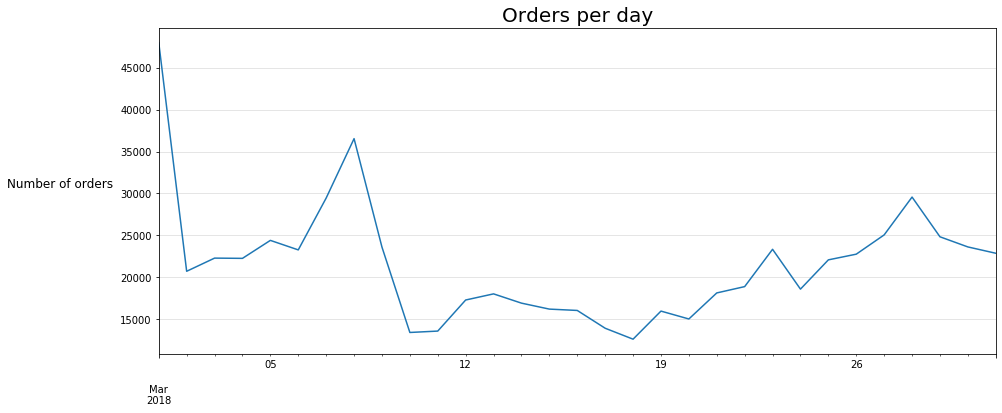

In [12]:
all_sku_day_month.plot(figsize = (15,6));
plt.title('Orders per day', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

## Orders per hour whole month

In [13]:
all_sku_hour_month = sku_orders_time.copy()

# floor it to the hour 
all_sku_hour_month.index = all_sku_hour_month.index.floor('H')

#value counts prepares it for plotting
all_sku_hour_month = all_sku_hour_month.index.value_counts()

# add a zero value for any minute without data
zeros = pd.Series(data = 0, index = [x for x in days_hours_march if not x in all_sku_hour_month])
all_sku_hour_month = all_sku_hour_month.append(zeros)

# sort_index for plotting
all_sku_hour_month = all_sku_hour_month.sort_index()

In [14]:
all_sku_hour_month

2018-03-01 00:00:00    2683
2018-03-01 01:00:00    1748
2018-03-01 02:00:00     421
2018-03-01 03:00:00     222
2018-03-01 04:00:00     159
                       ... 
2018-03-31 19:00:00    1015
2018-03-31 20:00:00    1231
2018-03-31 21:00:00    1463
2018-03-31 22:00:00    1679
2018-03-31 23:00:00    1201
Length: 744, dtype: int64

In [15]:
all_sku_hour_month.describe()

count     744.000000
mean      899.401882
std       640.383762
min        22.000000
25%       303.500000
50%       909.000000
75%      1313.000000
max      3666.000000
dtype: float64

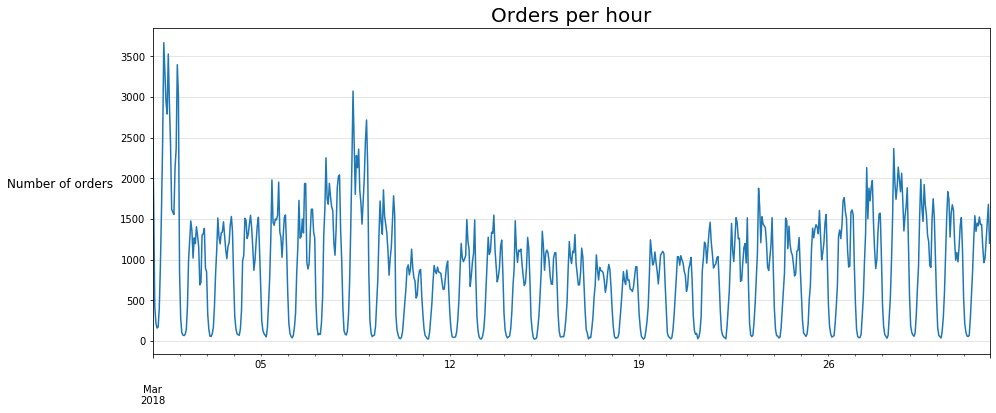

In [16]:
all_sku_hour_month.plot(figsize = (15,6));
plt.title('Orders per hour', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

## Orders per minute whole month

In [17]:
all_sku_minute_month = sku_orders_time.copy()

# floor it to the minute 
all_sku_minute_month.index = all_sku_minute_month.index.floor('min')

# value counts gets all of the orders that happened that hour
all_sku_minute_month = all_sku_minute_month.index.value_counts()

# add a zero value for any minute without data
zeros = pd.Series(data = 0, index = [x for x in days_hours_minutes_march if not x in all_sku_minute_month])
all_sku_minute_month = all_sku_minute_month.append(zeros)

# value counts gets all of the orders that happened that hour
all_sku_minute_month = all_sku_minute_month.sort_index()

In [18]:
all_sku_minute_month

2018-03-01 00:00:00    92
2018-03-01 00:01:00    56
2018-03-01 00:02:00    70
2018-03-01 00:03:00    52
2018-03-01 00:04:00    46
                       ..
2018-03-31 23:55:00    16
2018-03-31 23:56:00    18
2018-03-31 23:57:00    14
2018-03-31 23:58:00    19
2018-03-31 23:59:00    19
Length: 44640, dtype: int64

In [19]:
all_sku_minute_month.describe()

count    44640.000000
mean        14.990031
std         13.773613
min          0.000000
25%          4.000000
50%         14.000000
75%         22.000000
max        425.000000
dtype: float64

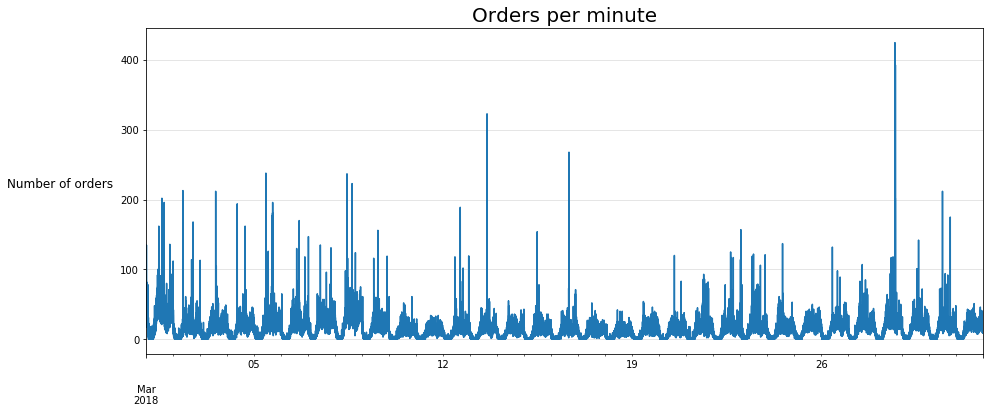

In [20]:
all_sku_minute_month.plot(figsize = (15,6));
plt.title('Orders per minute', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

## Per hour whole day

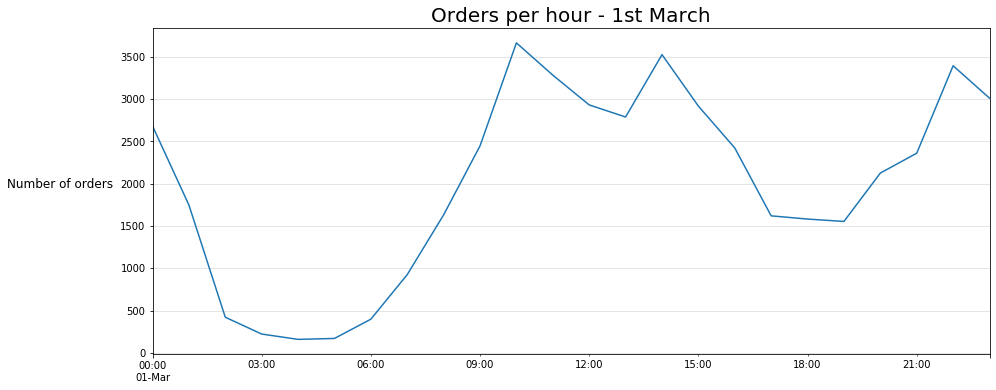

In [21]:
all_sku_hour_month[:24].plot(figsize = (15,6));
plt.title('Orders per hour - 1st March', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

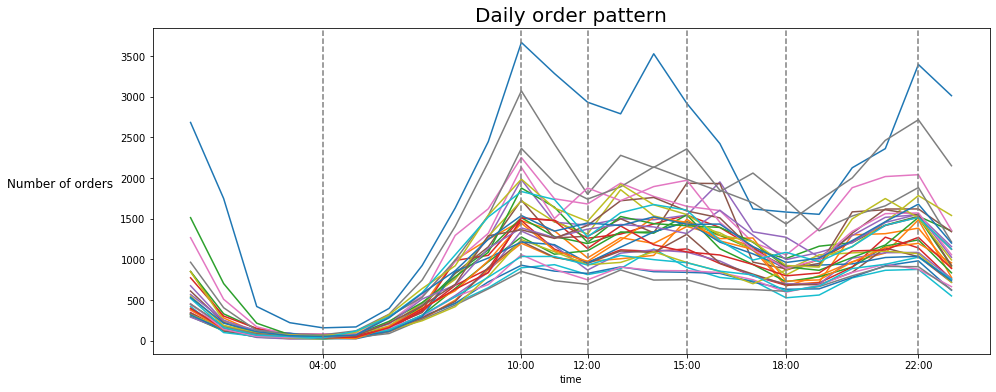

In [22]:
test = np.array_split(all_sku_hour_month, 31)

for i in test:
    i.index = i.index.time
    
test2 = pd.concat(test, axis = 1)

test2.columns = [m for m in days.itermonthdates(2018, 3) if m.month == 3]

ticks = [datetime.time(4), datetime.time(10), datetime.time(12), datetime.time(15), datetime.time(18), datetime.time(22)]

test2.plot(figsize = (15,6), legend=None)
plt.title('Daily order pattern', fontsize = 20)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);
plt.xticks(ticks= ticks);
plt.axvline(datetime.time(4), linestyle='--', color = 'grey')
plt.axvline(datetime.time(10), linestyle='--', color = 'grey')
plt.axvline(datetime.time(12), linestyle='--', color = 'grey')
plt.axvline(datetime.time(15), linestyle='--', color = 'grey')
plt.axvline(datetime.time(18), linestyle='--', color = 'grey')
plt.axvline(datetime.time(22), linestyle='--', color = 'grey');

## Per minute whole day

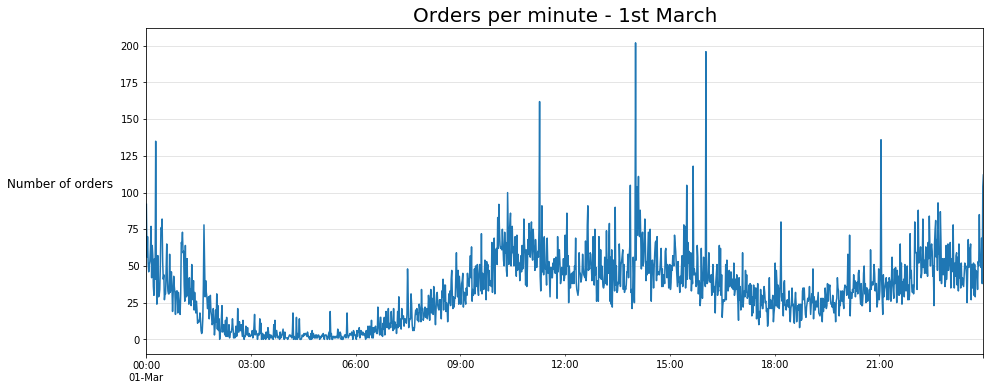

In [23]:
all_sku_minute_month[:1440].plot(figsize = (15,6));
plt.title('Orders per minute - 1st March', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

# Orders per item

## Bestselling SKUs per day whole month

In [24]:
# orders for the bestselling SKU "068f4481b3"

sku1_day_month = sku_orders_date[sku_orders_date.sku_ID == "068f4481b3"]
sku1_day_month = sku1_day_month.index.value_counts()

# add a zero value for any minute without data
zeros = pd.Series(data = 0, index = [x for x in days_march if not x in sku1_day_month])
sku1_day_month = sku1_day_month.append(zeros)

sku1_day_month.sort_index(inplace=True)

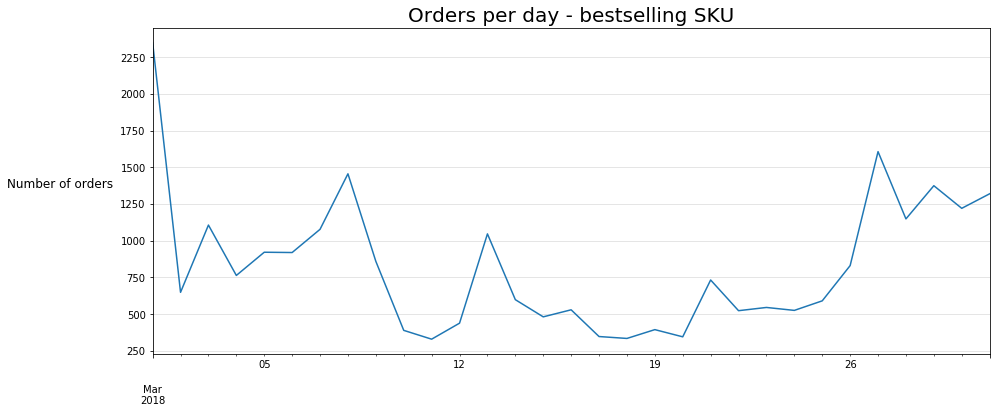

In [25]:
sku1_day_month.plot(figsize = (15, 6));
plt.title('Orders per day - bestselling SKU', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

In [26]:
# 15 bestselling SKUs

bestsellers = sku_orders_date.sku_ID.value_counts()
bloop = pd.DataFrame(index = [m for m in days.itermonthdates(2018, 3) if m.month == 3])

some_zeros = []
for sku in bestsellers.index:
    if bestsellers['{}'.format(sku)] > 5000:
        try:
            bloop['{}'.format(sku)] = sku_orders_date[sku_orders_date.sku_ID == sku].index.value_counts().sort_index().values
        except ValueError:
            some_zeros.append(sku)

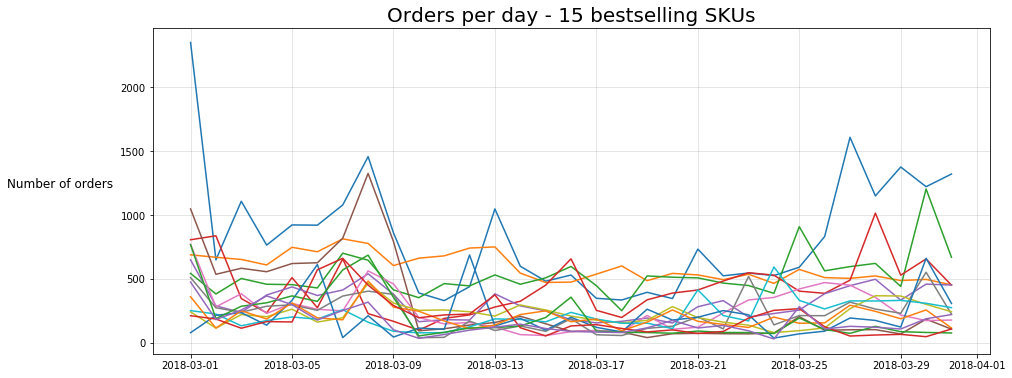

In [27]:
bloop.plot(figsize = (15, 6), legend = None)
plt.title('Orders per day - 15 bestselling SKUs', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

## Per Hour whole month

In [28]:
# bestselling SKU "068f4481b3"

sku1_hour_month = sku_orders_time[sku_orders_time.sku_ID == "068f4481b3"]

# floor it to the hour 
sku1_hour_month.index = sku1_hour_month.index.floor('H')

# value counts gets all of the orders that happened that hour
sku1_hour_month = sku1_hour_month.index.value_counts().sort_index()

# add a zero value for any minute without data
zeros = pd.Series(data = 0, index = [x for x in days_hours_march if not x in sku1_hour_month])
sku1_hour_month = sku1_hour_month.append(zeros)

sku1_hour_month.sort_index(inplace=True)

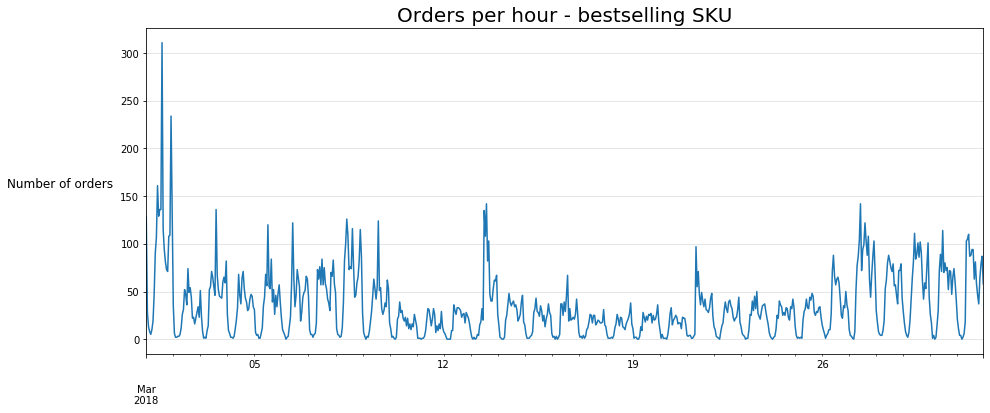

In [29]:
sku1_hour_month.plot(figsize = (15, 6));
plt.title('Orders per hour - bestselling SKU', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

In [30]:
# 15 bestselling SKUs

bloop = pd.DataFrame(index = [datetime.datetime(2018, 3, day, hour, 0, 0) for day in range(1, 32) for hour in range(24)])

for sku in bestsellers.index:
    if bestsellers['{}'.format(sku)] > 6400:
        
        sku1_hour_month = sku_orders_time[sku_orders_time.sku_ID == sku]
        
        # floor it to the hour 
        sku1_hour_month.index = sku1_hour_month.index.floor('H')

        # value counts gets all of the orders that happened that hour
        sku1_hour_month = sku1_hour_month.index.value_counts().sort_index()
        
        # add a zero value for any minute without data
        zeros = pd.Series(data = 0, index = [x for x in days_hours_march if not x in sku1_hour_month])
        sku1_hour_month = sku1_hour_month.append(zeros)
        
        sku1_hour_month.sort_index(inplace=True)
        
        try:
            bloop['{}'.format(sku)] = sku1_hour_month.values
        except ValueError:
            some_zeros.append(sku)

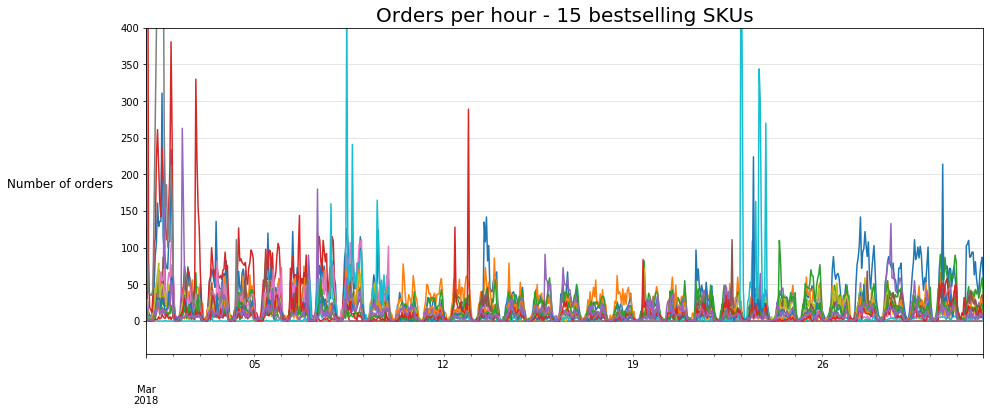

In [31]:
bloop.plot(figsize = (15, 6), legend = None);
plt.ylim(top = 400)
plt.title('Orders per hour - 15 bestselling SKUs', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

## Per minute whole month

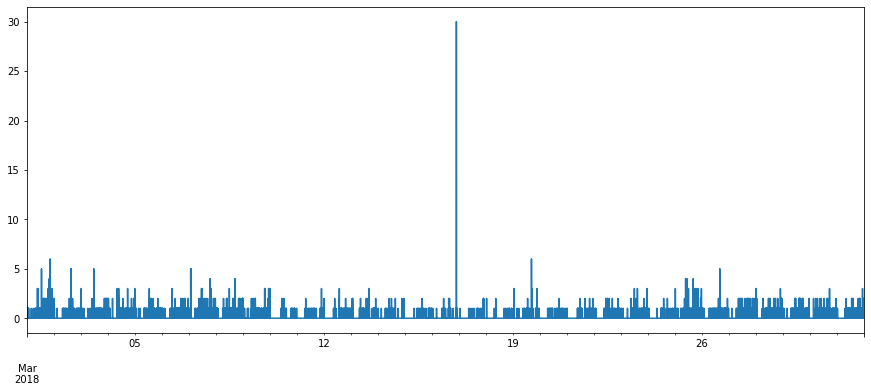

In [32]:
sku1_minute_month = sku_orders_time[sku_orders_time.sku_ID == "067b673f2b"]

# floor it to the minute 
sku1_minute_month.index = sku1_minute_month.index.floor('min')

# value counts gets all of the orders that happened that hour
sku1_minute_month = sku1_minute_month.index.value_counts().sort_index()

# add a zero value for any minute without data
zeros = pd.Series(data = 0, index = [x for x in days_hours_minutes_march if not x in sku1_minute_month])
sku1_minute_month = sku1_minute_month.append(zeros)

sku1_minute_month.sort_index(inplace=True)

sku1_minute_month.plot(figsize = (15, 6));

## Per hour whole day

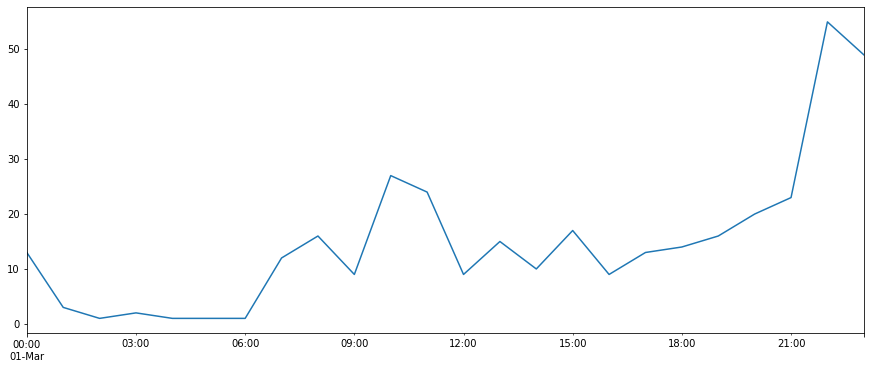

In [33]:
sku1_hour_month[:24].plot(figsize = (15, 6));

## Per minute whole day

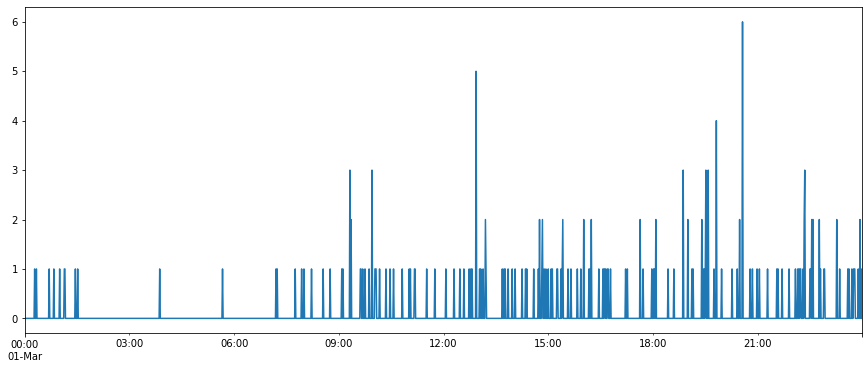

In [34]:
sku1_minute_month[:1440].plot(figsize = (15, 6));

# Exploring Auto Correlation

Going to use the orders per hour, over the course of the month to lose as little information as possible, without becoming too granular.

In [35]:
df = pd.DataFrame(all_sku_hour_month)
df.rename(columns = {0:"orders"}, inplace = True)
variable = "orders"

In [36]:
df['lag_1'] = df[variable].shift(1)
df['lag_2'] = df[variable].shift(2)
df['lag_3'] = df[variable].shift(3)
df['lag_5'] = df[variable].shift(5)
df['lag_6'] = df[variable].shift(6)
df['lag_7'] = df[variable].shift(7)
df['lag_10'] = df[variable].shift(10)
df['lag_20'] = df[variable].shift(20)
df['lag_22'] = df[variable].shift(22)
df['lag_23'] = df[variable].shift(23)
df['lag_24'] = df[variable].shift(24)
df['lag_25'] = df[variable].shift(25)
df['lag_26'] = df[variable].shift(26)

In [37]:
df

orders   lag_1   lag_2   lag_3   lag_5   lag_6   lag_7  \
2018-03-01 00:00:00    2683     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    1748  2683.0     NaN     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00     421  1748.0  2683.0     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00     222   421.0  1748.0  2683.0     NaN     NaN     NaN   
2018-03-01 04:00:00     159   222.0   421.0  1748.0     NaN     NaN     NaN   
...                     ...     ...     ...     ...     ...     ...     ...   
2018-03-31 19:00:00    1015   962.0  1158.0  1434.0  1523.0  1416.0  1448.0   
2018-03-31 20:00:00    1231  1015.0   962.0  1158.0  1430.0  1523.0  1416.0   
2018-03-31 21:00:00    1463  1231.0  1015.0   962.0  1434.0  1430.0  1523.0   
2018-03-31 22:00:00    1679  1463.0  1231.0  1015.0  1158.0  1434.0  1430.0   
2018-03-31 23:00:00    1201  1679.0  1463.0  1231.0   962.0  1158.0  1434.0   

                     lag_10  lag_20  lag_22  lag_23  lag_24  lag_25  lag_26  
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...                     ...     ...     ...     ...     ...     ...     ...  
2018-03-31 19:00:00  1247.0  1126.0  1419.0  1158.0   972.0  1087.0   992.0  
2018-03-31 20:00:00  1539.0   534.0  1516.0  1419.0  1158.0   972.0  1087.0  
2018-03-31 21:00:00  1347.0   216.0  1126.0  1516.0  1419.0  1158.0   972.0  
2018-03-31 22:00:00  1448.0   111.0   534.0  1126.0  1516.0  1419.0  1158.0  
2018-03-31 23:00:00  1416.0    62.0   216.0   534.0  1126.0  1516.0  1419.0  

[744 rows x 14 columns]

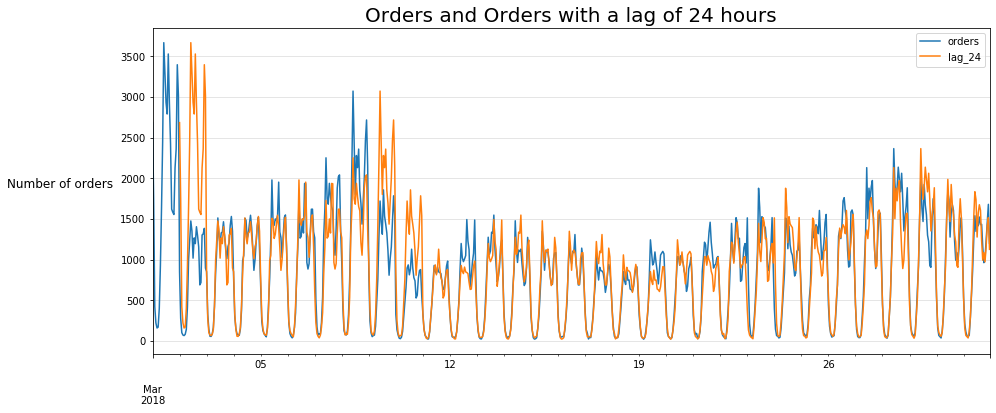

In [38]:
df[[variable, 'lag_24']].plot(figsize=(15,6))
plt.title('Orders and Orders with a lag of 24 hours', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

In [39]:
df.corr()

orders     lag_1     lag_2     lag_3     lag_5     lag_6     lag_7  \
orders  1.000000  0.884333  0.685767  0.482230  0.162815  0.044315 -0.063476   
lag_1   0.884333  1.000000  0.884570  0.685663  0.305618  0.162776  0.044064   
lag_2   0.685767  0.884570  1.000000  0.884472  0.482253  0.305762  0.162281   
lag_3   0.482230  0.685663  0.884472  1.000000  0.685786  0.482393  0.305468   
lag_5   0.162815  0.305618  0.482253  0.685786  1.000000  0.884538  0.685837   
lag_6   0.044315  0.162776  0.305762  0.482393  0.884538  1.000000  0.884585   
lag_7  -0.063476  0.044064  0.162281  0.305468  0.685837  0.884585  1.000000   
lag_10 -0.173273 -0.188126 -0.152313 -0.066800  0.160802  0.305069  0.482201   
lag_20  0.217291  0.075070 -0.046618 -0.161144 -0.272631 -0.230483 -0.163686   
lag_22  0.605528  0.403451  0.221350  0.079465 -0.160073 -0.246465 -0.272243   
lag_23  0.771950  0.606949  0.406267  0.223126 -0.043669 -0.159982 -0.246004   
lag_24  0.839876  0.772744  0.608936  0.407417  0.080639 -0.043561 -0.159669   
lag_25  0.752395  0.839859  0.773157  0.608919  0.223613  0.080572 -0.043807   
lag_26  0.579407  0.752279  0.839671  0.772849  0.407208  0.223555  0.079995   

          lag_10    lag_20    lag_22    lag_23    lag_24    lag_25    lag_26  
orders -0.173273  0.217291  0.605528  0.771950  0.839876  0.752395  0.579407  
lag_1  -0.188126  0.075070  0.403451  0.606949  0.772744  0.839859  0.752279  
lag_2  -0.152313 -0.046618  0.221350  0.406267  0.608936  0.773157  0.839671  
lag_3  -0.066800 -0.161144  0.079465  0.223126  0.407417  0.608919  0.772849  
lag_5   0.160802 -0.272631 -0.160073 -0.043669  0.080639  0.223613  0.407208  
lag_6   0.305069 -0.230483 -0.246465 -0.159982 -0.043561  0.080572  0.223555  
lag_7   0.482201 -0.163686 -0.272243 -0.246004 -0.159669 -0.043807  0.079995  
lag_10  1.000000 -0.173930 -0.117521 -0.159852 -0.227213 -0.271531 -0.247905  
lag_20 -0.173930  1.000000  0.683904  0.479594  0.302954  0.161709  0.045946  
lag_22 -0.117521  0.683904  1.000000  0.883381  0.683229  0.480387  0.306133  
lag_23 -0.159852  0.479594  0.883381  1.000000  0.883434  0.684345  0.482494  
lag_24 -0.227213  0.302954  0.683229  0.883434  1.000000  0.883986  0.685692  
lag_25 -0.271531  0.161709  0.480387  0.684345  0.883986  1.000000  0.884153  
lag_26 -0.247905  0.045946  0.306133  0.482494  0.685692  0.884153  1.000000

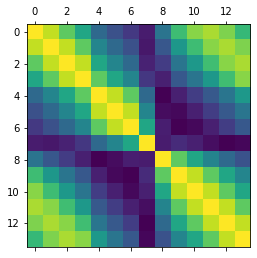

In [40]:
plt.matshow(df.corr())
plt.show()

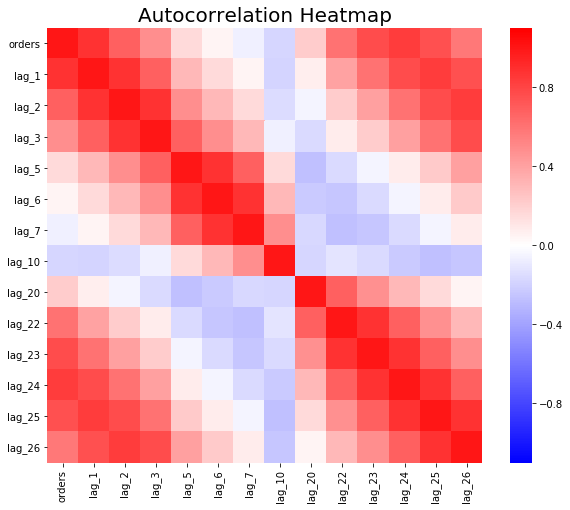

In [41]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, square = True, vmin = -1.1, vmax = 1.1, cmap='bwr')
plt.yticks(rotation=0);
plt.title('Autocorrelation Heatmap', fontsize = 20);

C:\Users\shane\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\shane\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


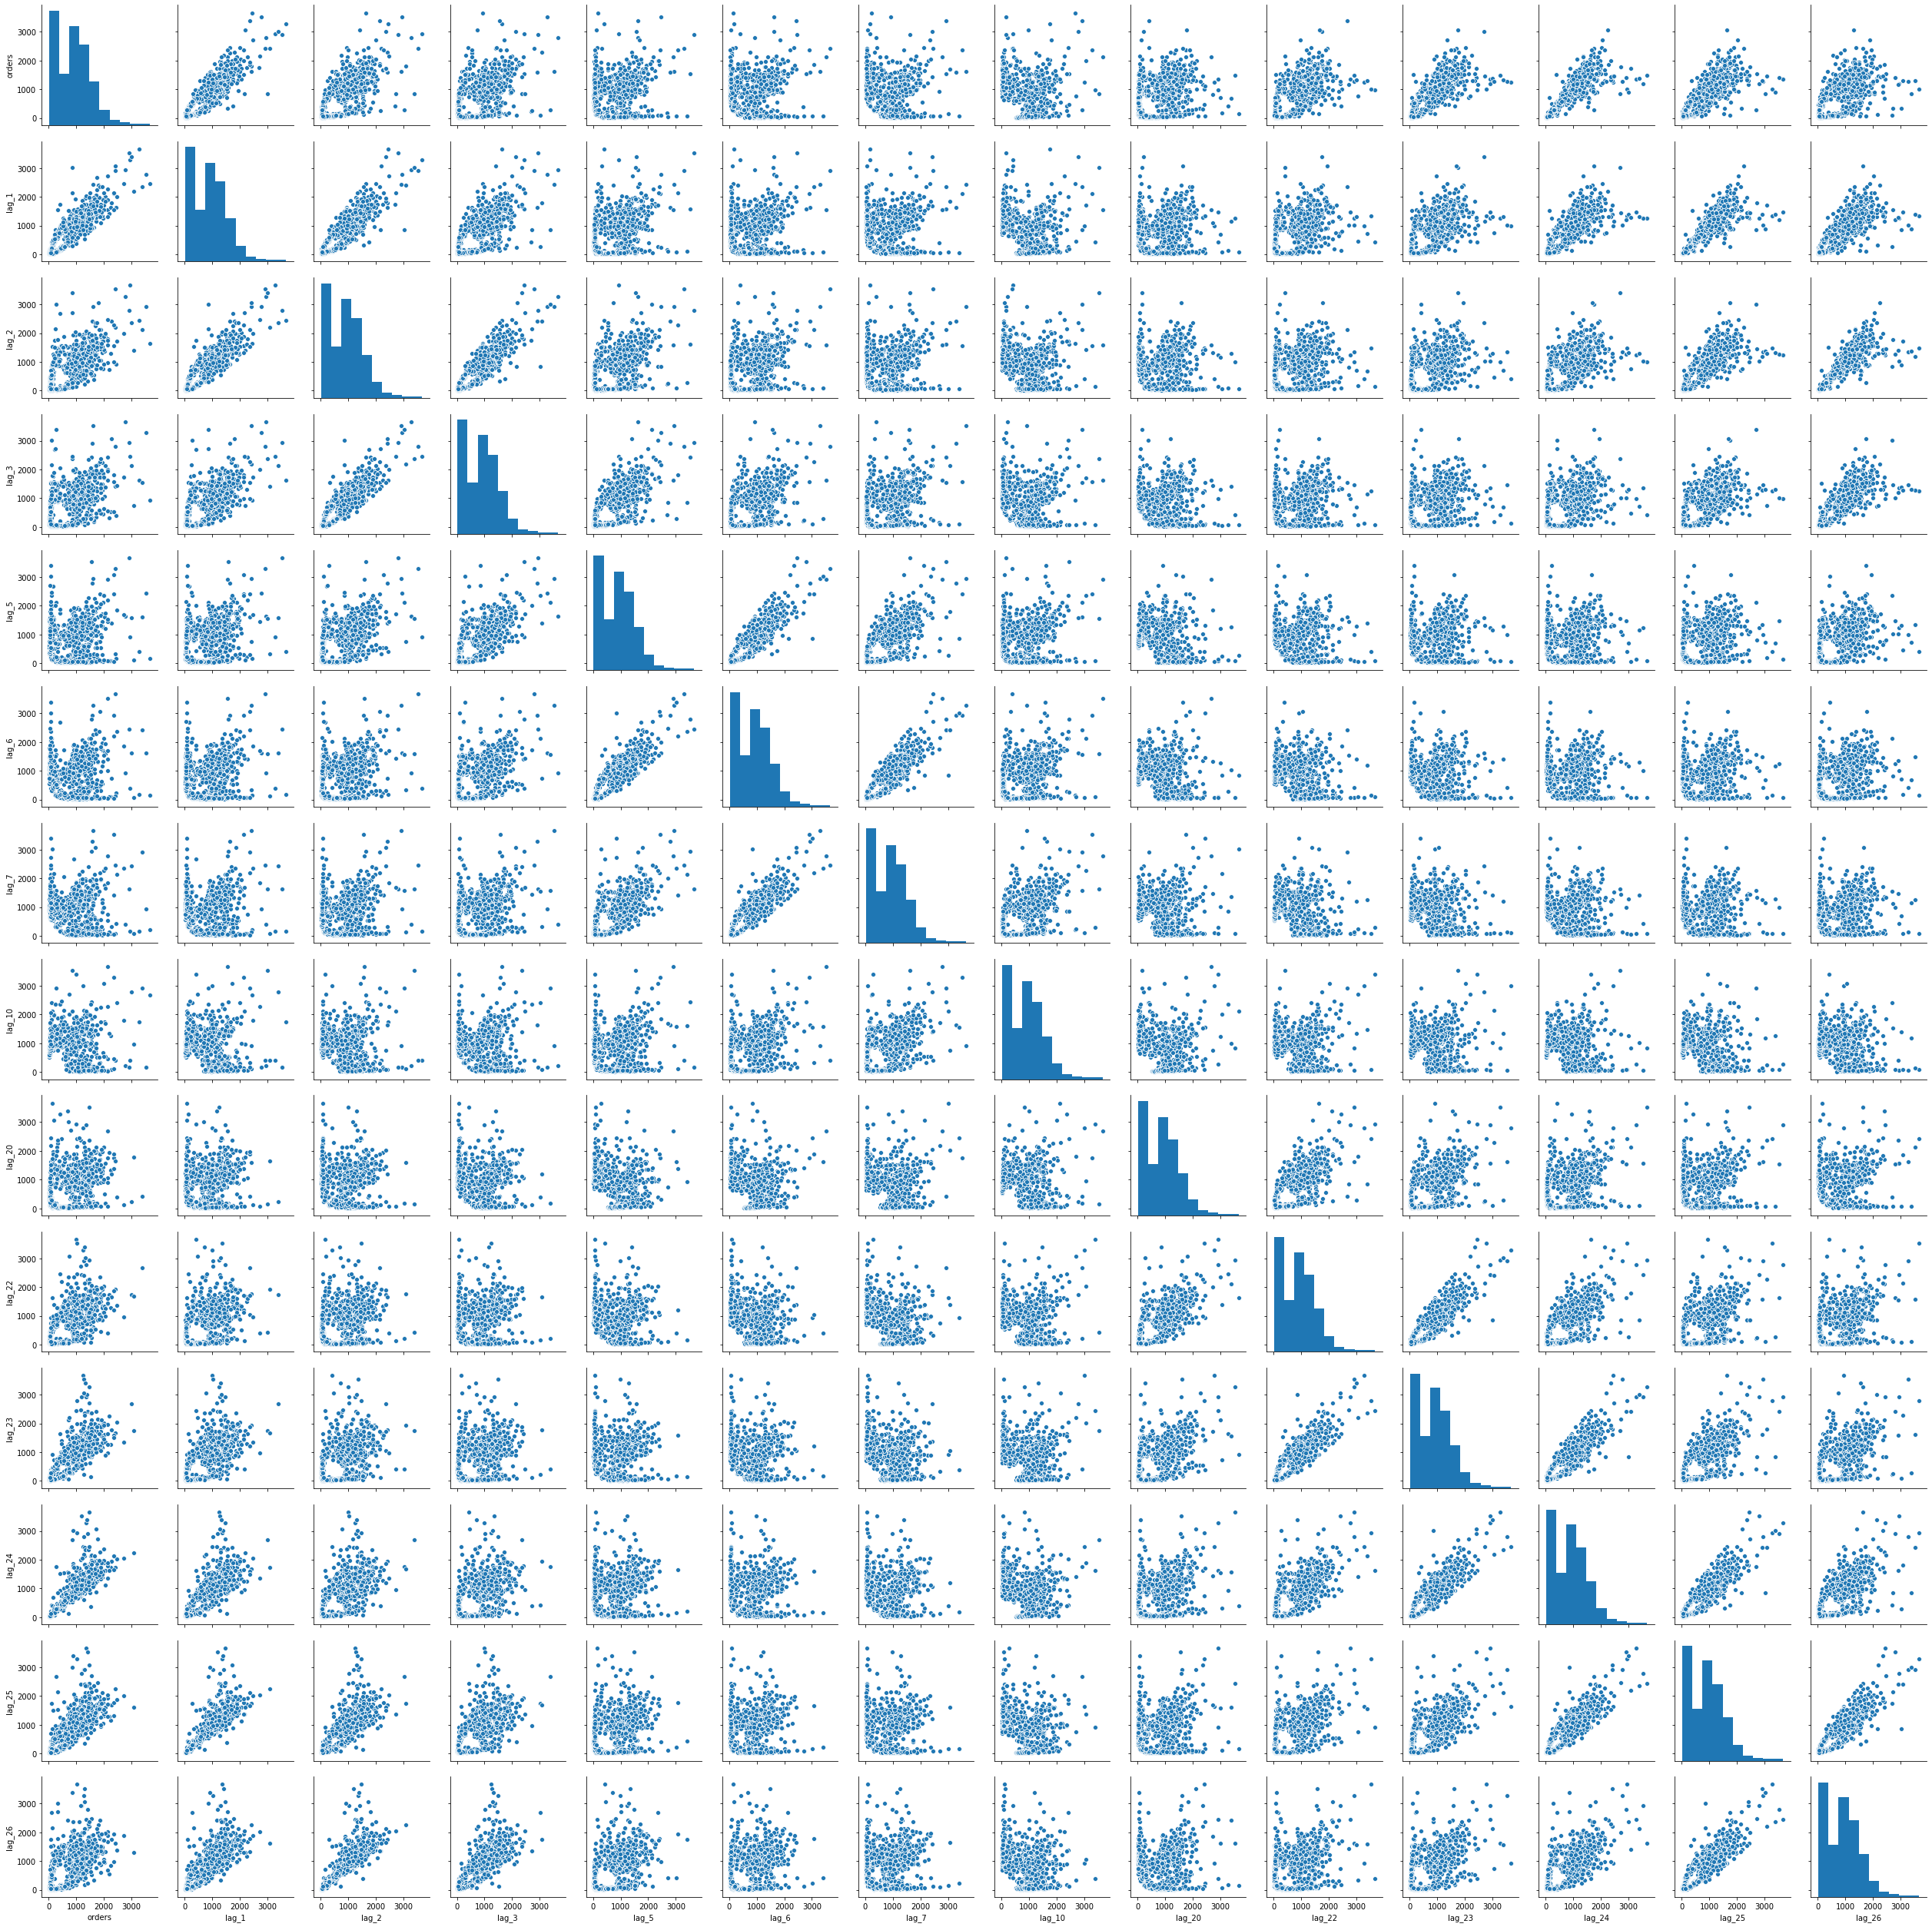

In [42]:
sns.pairplot(df);

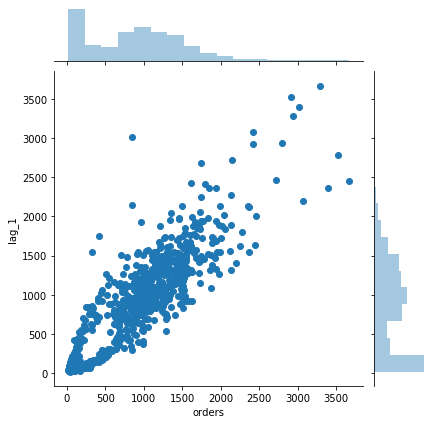

In [43]:
sns.jointplot(df[variable], df['lag_1']);

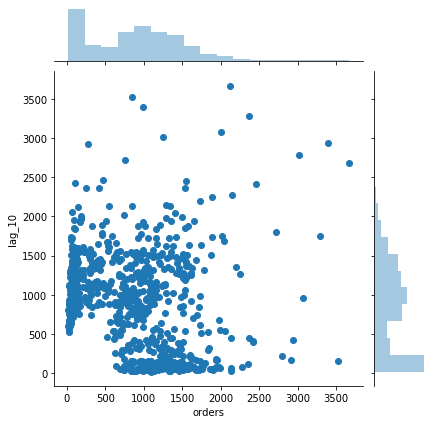

In [44]:
sns.jointplot(df[variable], df['lag_10']);

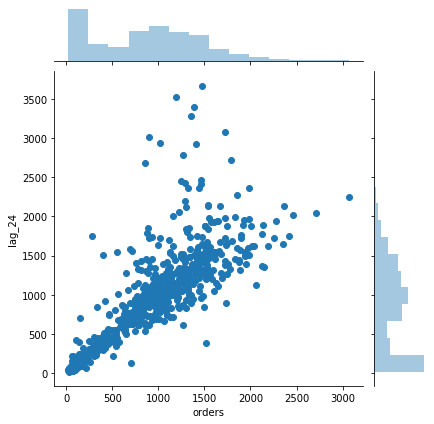

In [45]:
sns.jointplot(df[variable], df['lag_24']);

In [46]:
sm.tsa.stattools.acf(df[variable])

C:\Users\shane\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.87956875,  0.68058137,  0.478159  ,  0.30281955,
        0.16113992,  0.04381753, -0.06273581, -0.14797511, -0.18479585,
       -0.17008748, -0.13413266, -0.11415665, -0.1544931 , -0.21766789,
       -0.25560934, -0.23077066, -0.15149968, -0.04531011,  0.06822282,
        0.19912591,  0.36652317,  0.54891648,  0.6903401 ,  0.74389867,
        0.66639905,  0.5126065 ,  0.34174972,  0.18650463,  0.0662473 ,
       -0.03681354, -0.13810663, -0.21920121, -0.25797004, -0.24290106,
       -0.20770633, -0.18693616, -0.21524385, -0.26104239, -0.27802917,
       -0.24314149])

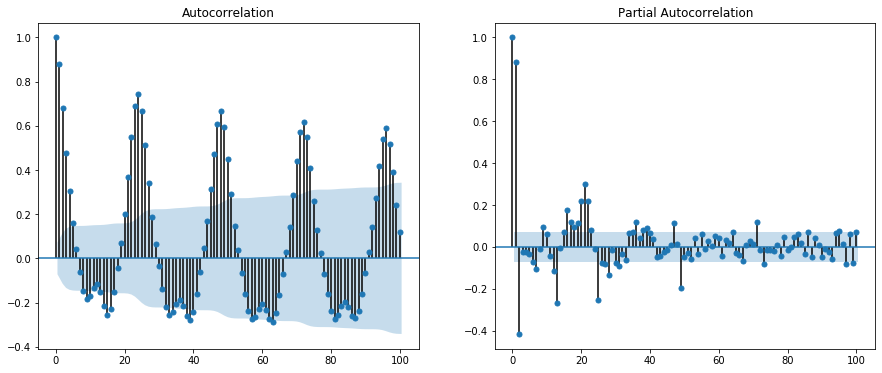

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig = sm.graphics.tsa.plot_acf(df[variable], lags=100, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df[variable], lags=100, ax=axes[1]) 

# Seasonal decomposition

## Naive seasonal decomposition

In [48]:
naive_decomposition = sm.tsa.seasonal_decompose(df[variable], 
                                          model='additive')

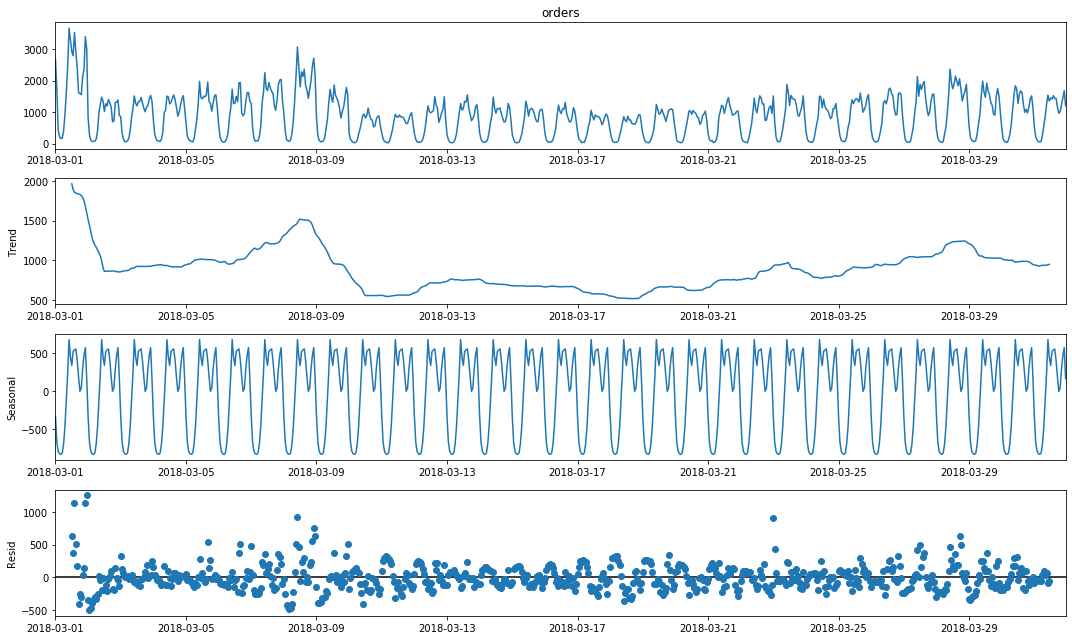

In [49]:
old_rcParams = rcParams['figure.figsize']
rcParams['figure.figsize'] = 15, 9      

naive_decomposition.plot()
plt.show()

rcParams['figure.figsize'] = old_rcParams    

## STL seasonal decomposition

In [50]:
import statsmodels as sm

In [51]:
stl_decomposition = sm.tsa.seasonal.STL(df[variable]).fit()

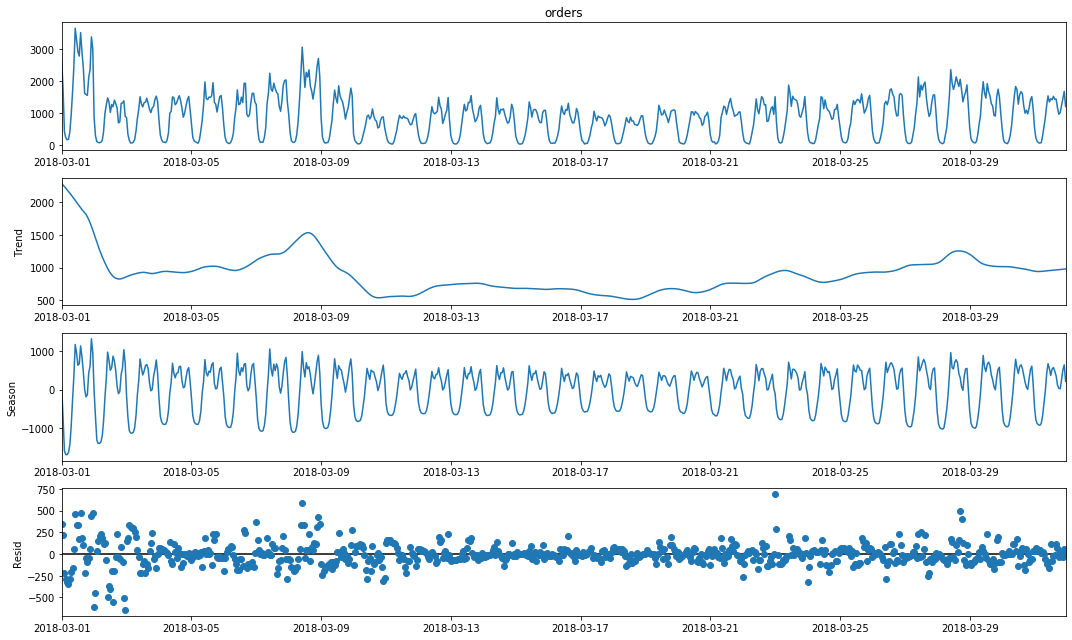

In [52]:
old_rcParams = rcParams['figure.figsize']
rcParams['figure.figsize'] = 15, 9      

stl_decomposition.plot()
plt.show();

rcParams['figure.figsize'] = old_rcParams    